In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER Paris DATA FROM ALL AVAILABLE YEARS
Paris_Data = pd.read_csv('Paris_data.csv', index_col=0)

In [4]:
#Paris DATA PREVIEW
Paris_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windspeed,winddir
2014-12-29,0.507692,0.070248,0.338235,0.411765,0.204082,0.106667,0.321637,0.698413,0.274809,0.857354
2014-12-30,0.567033,0.086777,0.338235,0.372549,0.204082,0.194667,0.429825,0.755556,0.137405,0.900266
2014-12-31,0.778022,0.070248,0.544118,0.542484,0.204082,0.197333,0.406433,0.668254,0.030534,0.614679
2015-01-01,0.679121,0.188017,0.529412,0.666667,0.153061,0.141333,0.365497,0.734921,0.254453,0.554306
2015-01-02,0.567033,0.128099,0.308824,0.405229,0.102041,0.248000,0.491228,0.766667,0.353690,0.665877
...,...,...,...,...,...,...,...,...,...,...
2022-03-14,0.285714,0.450413,0.161765,0.156863,0.020408,0.357333,0.540936,0.603175,0.206107,0.444510
2022-03-15,0.463736,0.198347,0.147059,0.235294,0.020408,0.373333,0.652047,0.847619,0.170483,0.311927
2022-03-16,0.373626,0.126033,0.397059,0.326797,0.020408,0.402667,0.666667,0.793651,0.376590,0.438591
2022-03-17,0.178022,0.469008,0.147059,0.183007,0.020408,0.338667,0.540936,0.614286,0.402036,0.371412


## Data Preparation for Univariate Models

In [5]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Paris_Data_uni = Paris_Data.loc[:, Paris_Data.columns.intersection(cols)]
Paris_Data_uni = Paris_Data_uni.apply(pd.to_numeric, errors='coerce')

#FILL NAN VALUES
Paris_Data_uni = Paris_Data_uni.iloc[1: , :]

#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Paris_Data_uni = Paris_Data_uni.replace(r'^\s*$', np.nan, regex=True)
Paris_Data_uni = Paris_Data_uni.fillna(method='ffill')
Paris_Data_uni = Paris_Data_uni.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Paris_Data_uni = Paris_Data_uni[~Paris_Data_uni.index.duplicated(keep='first')]

In [6]:
#UNIVARIATE DATA PREVIEW
Paris_Data_uni

,no2,o3,pm10,pm25,so2
2014-12-30,0.567033,0.086777,0.338235,0.372549,0.204082
2014-12-31,0.778022,0.070248,0.544118,0.542484,0.204082
2015-01-01,0.679121,0.188017,0.529412,0.666667,0.153061
2015-01-02,0.567033,0.128099,0.308824,0.405229,0.102041
2015-01-03,0.356044,0.163223,0.102941,0.228758,0.051020
...,...,...,...,...,...
2022-03-14,0.285714,0.450413,0.161765,0.156863,0.020408
2022-03-15,0.463736,0.198347,0.147059,0.235294,0.020408
2022-03-16,0.373626,0.126033,0.397059,0.326797,0.020408
2022-03-17,0.178022,0.469008,0.147059,0.183007,0.020408


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Paris_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windspeed', 'winddir'],
      dtype='object')

In [8]:
#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Paris_Data = Paris_Data.replace(r'^\s*$', np.nan, regex=True)

#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Paris_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [9]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Paris_Data_multi = Paris_Data.loc[:, Paris_Data.columns.intersection(cols)]
Paris_Data_multi = Paris_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Paris_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [11]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Paris_Data_multi = Paris_Data_multi.iloc[1: , :]
#Paris_Data_multi = Paris_Data_multi.fillna(method='bfill')
#Paris_Data_multi = Paris_Data_multi.fillna(method='ffill')
Paris_Data_multi = Paris_Data_multi.dropna()
(Paris_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [12]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Paris_o3 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Paris_so2 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Paris_no2 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Paris_pm25 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Paris_pm10 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Paris_o3, Paris_no2, Paris_so2, Paris_pm10, Paris_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Paris_o3

,o3,temp,dew,humidity,windspeed,winddir
2014-12-30,0.086777,0.194667,0.429825,0.755556,0.137405,0.900266
2014-12-31,0.070248,0.197333,0.406433,0.668254,0.030534,0.614679
2015-01-01,0.188017,0.141333,0.365497,0.734921,0.254453,0.554306
2015-01-02,0.128099,0.248000,0.491228,0.766667,0.353690,0.665877
2015-01-03,0.163223,0.288000,0.587719,0.926984,0.669211,0.611719
...,...,...,...,...,...,...
2022-03-14,0.450413,0.357333,0.540936,0.603175,0.206107,0.444510
2022-03-15,0.198347,0.373333,0.652047,0.847619,0.170483,0.311927
2022-03-16,0.126033,0.402667,0.666667,0.793651,0.376590,0.438591
2022-03-17,0.469008,0.338667,0.540936,0.614286,0.402036,0.371412


# UNIVARIATE CNN

In [26]:
def Uni_CNN():
    preds = [] 
    tests = [] 
    #n_steps = 7
    n_features = 1

    #CNN UNIVARIATE MODEL
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    for col in Paris_Data_uni.columns:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(Paris_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], n_features))

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(tests)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Univariate CNN MSE for Paris[" + str(col) + "]:" + str(mse))
        print("Univariate CNN RMSE for Paris[" + str(col) + "]:" + str(rmse))
        print("Univariate CNN MAE for Paris[" + str(col) + "]:" + str(mae))
        #print("Univariate CNN MAPE for Paris[" + str(col) + "]:" + str(mape))

        title = "Univariate CNN for Paris_Data" + "[" + col +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE CNN

In [27]:
def Multi_CNN():
    preds = []
    tests = []
    
    #n_steps=7

    for data in datasets:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features= window.shape[2]

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #MULTIVARIATE CNN MODEL
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=2, input_shape=(n_steps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate CNN MSE for Paris[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate CNN RMSE for Paris[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate CNN MAE for Paris[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate CNN MAPE for Paris[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Multivariate CNN for Paris[" + str(data.columns[0]) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    
    return preds, tests

# UNIVARIATE LSTM

In [28]:
def Uni_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for col in Paris_Data_uni.columns:
        window, output = split_ts_by_window(Paris_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], 1))

        #UNIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
        lstm_model.add(Dense(30,activation='relu'))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1,activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Univariate LSTM MSE for Paris[" + str(col) + "]:" + str(mse_ucnn))
        print("Univariate LSTM RMSE for Paris[" + str(col) + "]:" + str(rmse_ucnn))
        print("Univariate LSTM MAE for Paris[" + str(col) + "]:" + str(mae_ucnn))
        #print("Univariate LSTM MAPE for Paris[" + str(col) + "]:" + str(mape_ucnn))

        title = "Univariate LSTM for Paris[" + str(col) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE LSTM

In [29]:
def Multi_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for data in datasets:
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features = window.shape[2]


        #MULTIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
        lstm_model.add(Dense(30))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate LSTM MSE for Paris[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate LSTM RMSE for Paris[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate LSTM MAE for Paris[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate LSTM MAPE for Paris[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Mutlivariate LSTM for Paris" + "[" + str(data.columns[0]) +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

Univariate CNN MSE for Paris[no2]:0.017013442
Univariate CNN RMSE for Paris[no2]:0.13043558475841185
Univariate CNN MAE for Paris[no2]:0.10220367
Univariate CNN MAPE for Paris[no2]:0.66231066


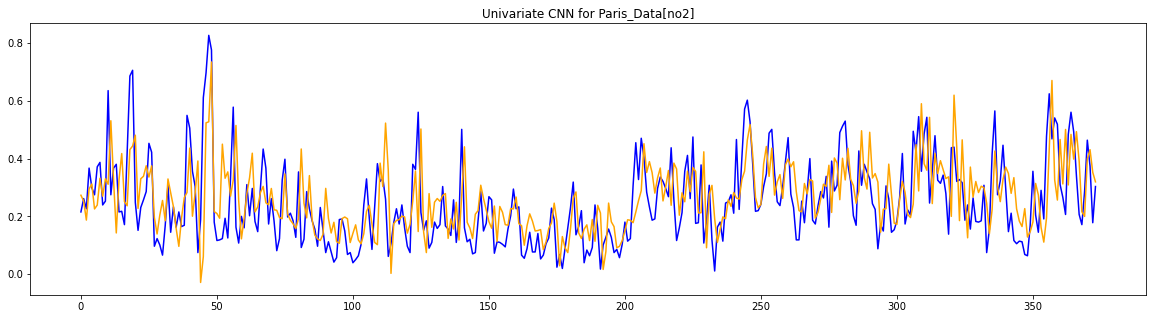

Univariate CNN MSE for Paris[o3]:0.020384891
Univariate CNN RMSE for Paris[o3]:0.1427756665495448
Univariate CNN MAE for Paris[o3]:0.11028908
Univariate CNN MAPE for Paris[o3]:0.9636697


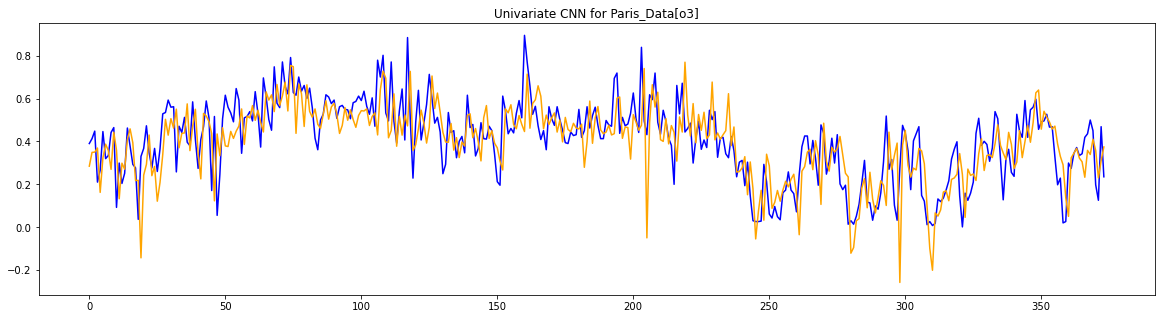

Univariate CNN MSE for Paris[pm10]:0.013411263
Univariate CNN RMSE for Paris[pm10]:0.11580700757702597
Univariate CNN MAE for Paris[pm10]:0.08820645
Univariate CNN MAPE for Paris[pm10]:2141977700000.0


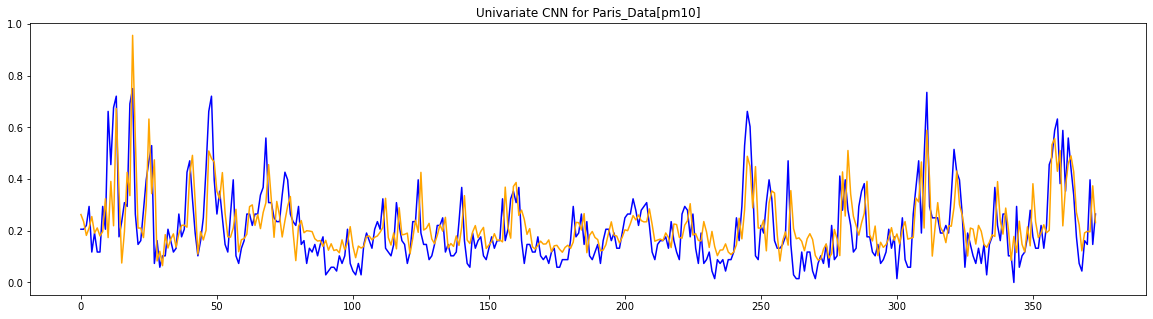

Univariate CNN MSE for Paris[pm25]:0.010901288
Univariate CNN RMSE for Paris[pm25]:0.10440923392779627
Univariate CNN MAE for Paris[pm25]:0.08140353
Univariate CNN MAPE for Paris[pm25]:1776836500000.0


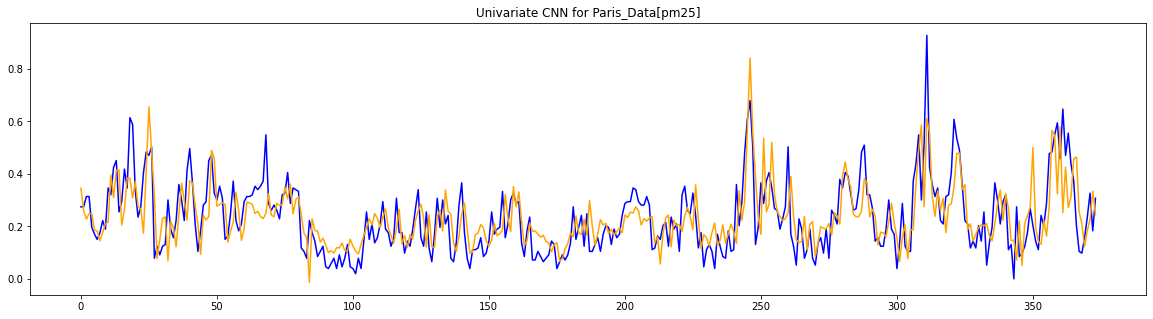

Univariate CNN MSE for Paris[so2]:0.00261259
Univariate CNN RMSE for Paris[so2]:0.051113502044987984
Univariate CNN MAE for Paris[so2]:0.033615023
Univariate CNN MAPE for Paris[so2]:13999363000000.0


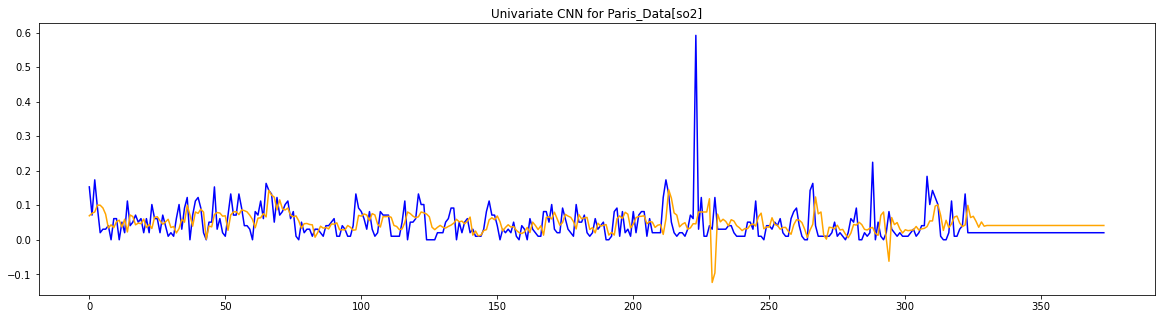

Multivariate CNN MSE for Paris[o3]:0.0010848695
Multivariate CNN RMSE for Paris[o3]:0.032937357129279345
Multivariate CNN MAE for Paris[o3]:0.025287716
Multivariate CNN MAPE for Paris[o3]:0.1653427


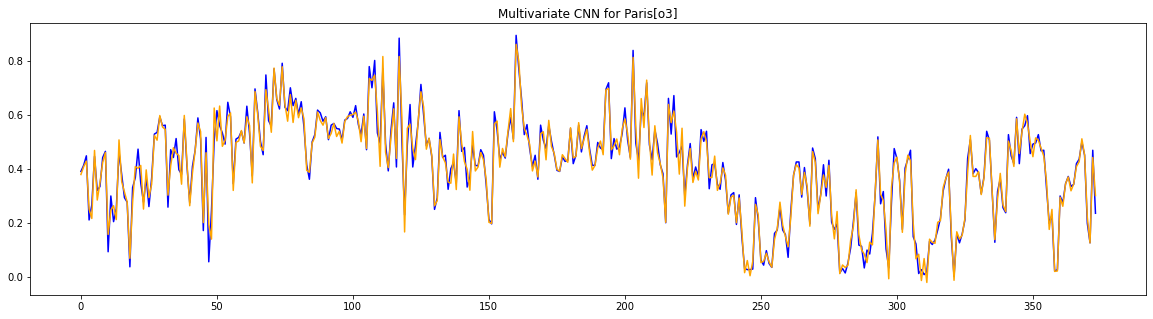

Multivariate CNN MSE for Paris[no2]:0.00083663955
Multivariate CNN RMSE for Paris[no2]:0.028924722101549637
Multivariate CNN MAE for Paris[no2]:0.02321244
Multivariate CNN MAPE for Paris[no2]:0.15275414


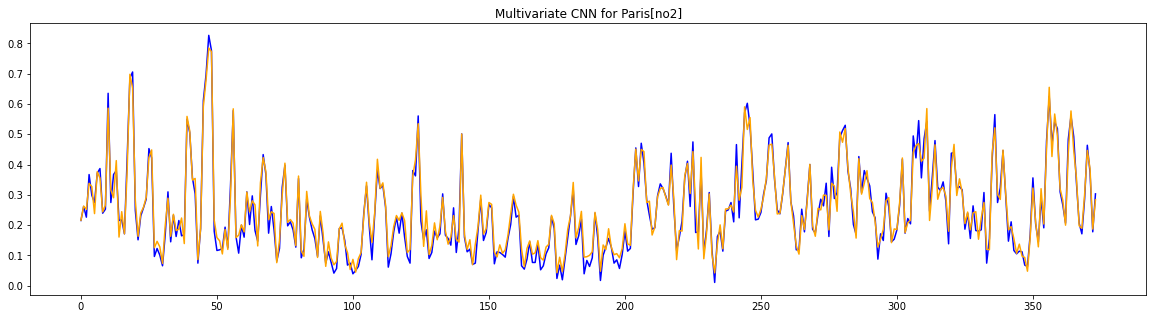

Multivariate CNN MSE for Paris[so2]:0.00024904817
Multivariate CNN RMSE for Paris[so2]:0.01578126012393419
Multivariate CNN MAE for Paris[so2]:0.012690077
Multivariate CNN MAPE for Paris[so2]:4715253000000.0


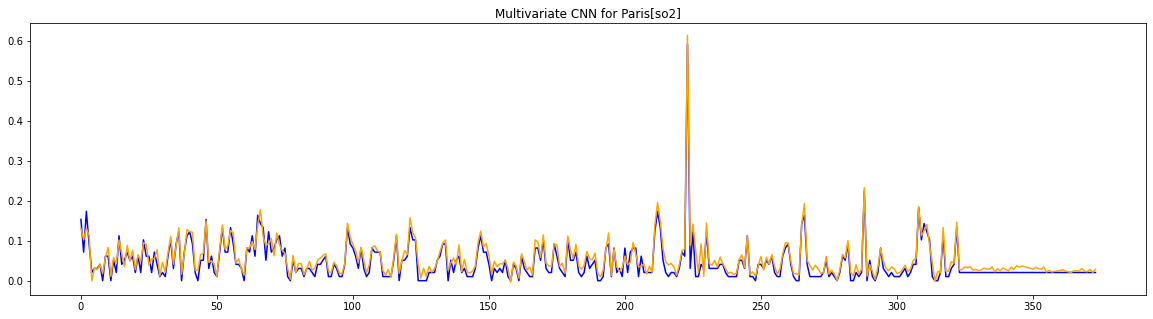

Multivariate CNN MSE for Paris[pm10]:0.0009576406
Multivariate CNN RMSE for Paris[pm10]:0.03094576847358769
Multivariate CNN MAE for Paris[pm10]:0.024051014
Multivariate CNN MAPE for Paris[pm10]:220686600000.0


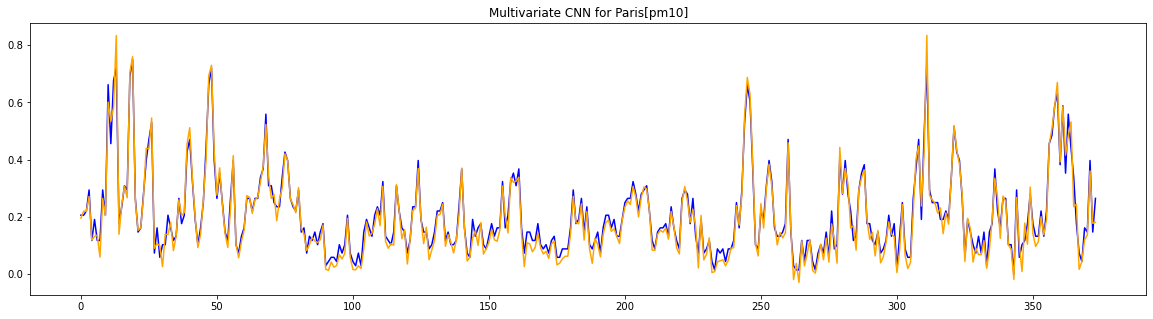

Multivariate CNN MSE for Paris[pm25]:0.0005456173
Multivariate CNN RMSE for Paris[pm25]:0.023358452632804023
Multivariate CNN MAE for Paris[pm25]:0.018251361
Multivariate CNN MAPE for Paris[pm25]:143878720000.0


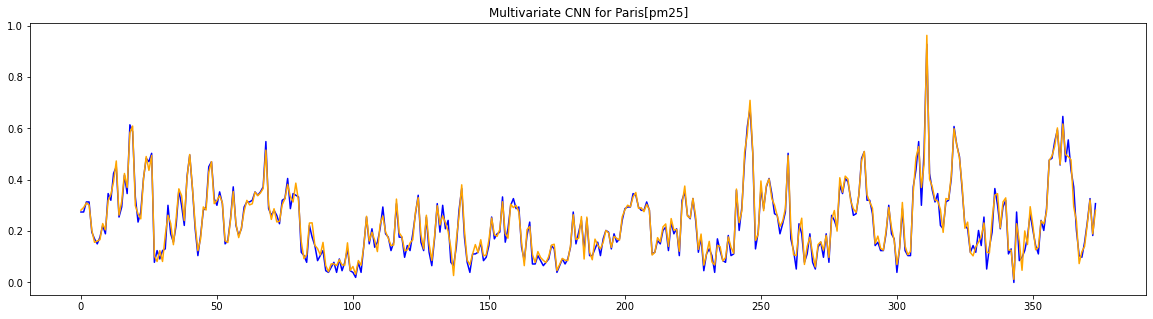

In [30]:
n_steps=7

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()

Univariate LSTM MSE for Paris[no2]:0.013297621
Univariate LSTM RMSE for Paris[no2]:0.11531531190932807
Univariate LSTM MAE for Paris[no2]:0.091219775
Univariate LSTM MAPE for Paris[no2]:0.6045008


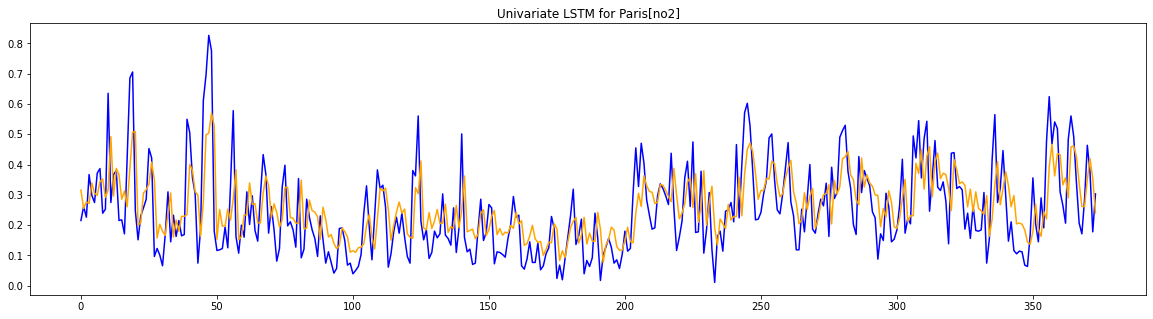

Univariate LSTM MSE for Paris[o3]:0.014852248
Univariate LSTM RMSE for Paris[o3]:0.12186979991872003
Univariate LSTM MAE for Paris[o3]:0.0941269
Univariate LSTM MAPE for Paris[o3]:0.8864412


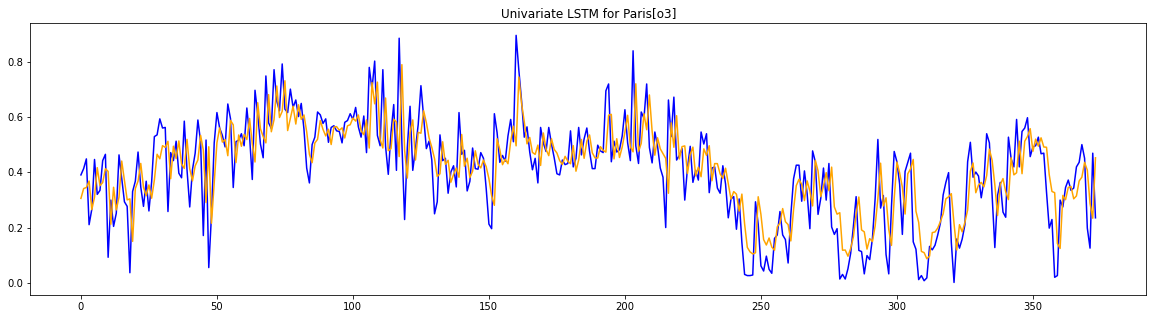

Univariate LSTM MSE for Paris[pm10]:0.011762133
Univariate LSTM RMSE for Paris[pm10]:0.10845336725141703
Univariate LSTM MAE for Paris[pm10]:0.0808222
Univariate LSTM MAPE for Paris[pm10]:1797734100000.0


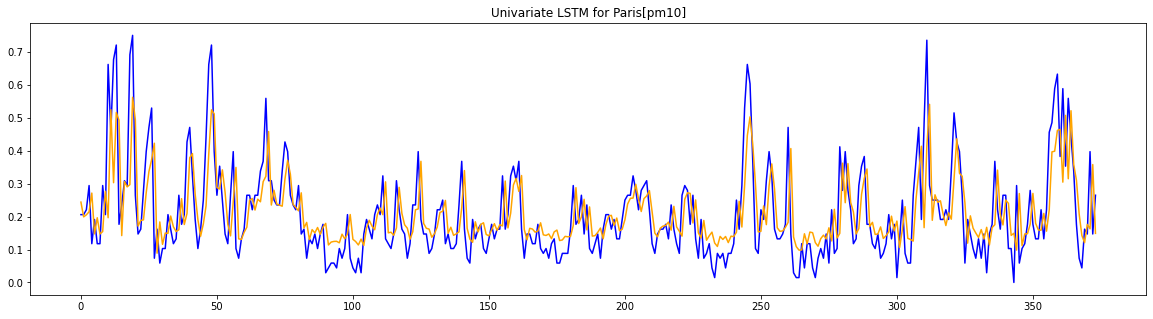

Univariate LSTM MSE for Paris[pm25]:0.009853449
Univariate LSTM RMSE for Paris[pm25]:0.09926453908010775
Univariate LSTM MAE for Paris[pm25]:0.07698409
Univariate LSTM MAPE for Paris[pm25]:2109283600000.0


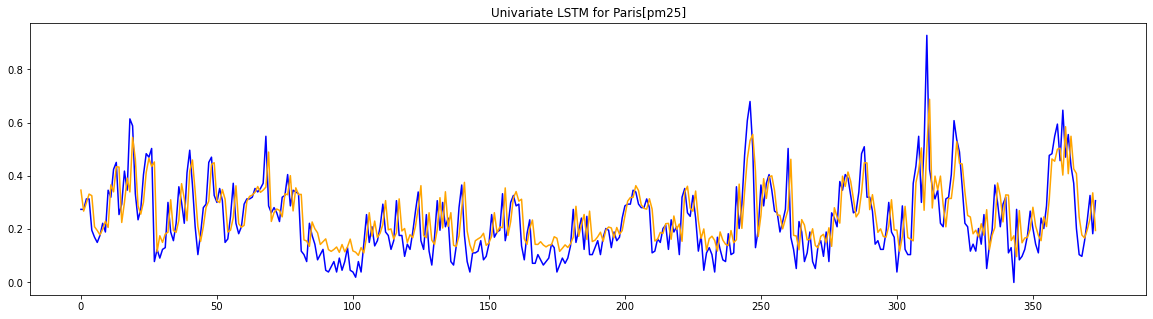

Univariate LSTM MSE for Paris[so2]:0.0022759084
Univariate LSTM RMSE for Paris[so2]:0.04770648138194306
Univariate LSTM MAE for Paris[so2]:0.032662276
Univariate LSTM MAPE for Paris[so2]:18159675000000.0


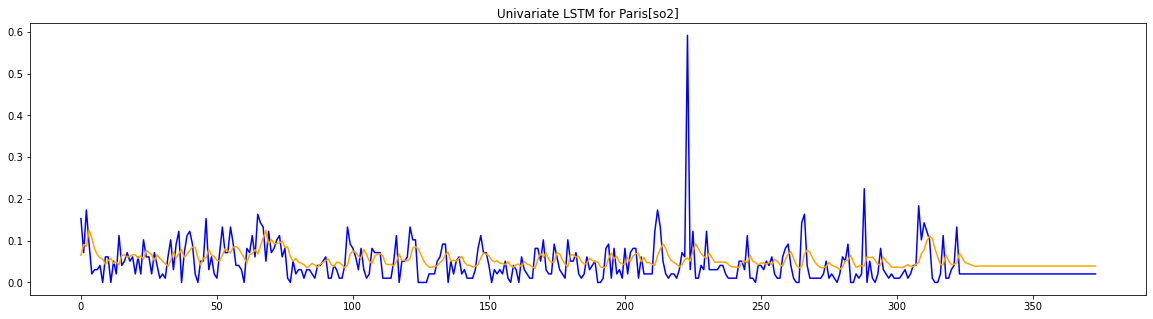

Multivariate LSTM MSE for Paris[o3]:2.762742e-05
Multivariate LSTM RMSE for Paris[o3]:0.005256179260879965
Multivariate LSTM MAE for Paris[o3]:0.0041834856
Multivariate LSTM MAPE for Paris[o3]:0.02154698


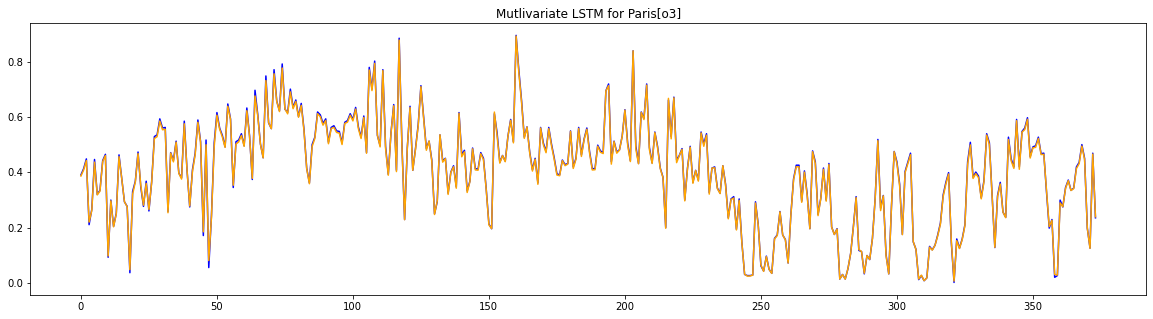

Multivariate LSTM MSE for Paris[no2]:7.0857684e-05
Multivariate LSTM RMSE for Paris[no2]:0.008417700664506454
Multivariate LSTM MAE for Paris[no2]:0.0073845214
Multivariate LSTM MAPE for Paris[no2]:0.060660917


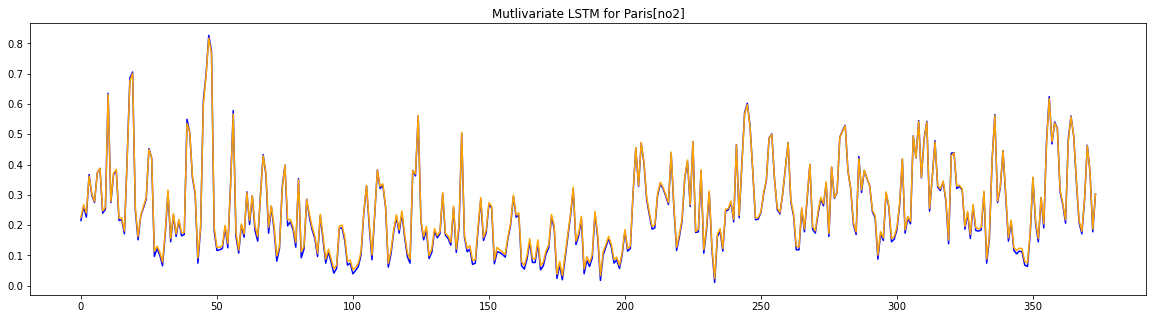

Multivariate LSTM MSE for Paris[so2]:3.4832722e-06
Multivariate LSTM RMSE for Paris[so2]:0.0018663526372860006
Multivariate LSTM MAE for Paris[so2]:0.0014880261
Multivariate LSTM MAPE for Paris[so2]:344396960000.0


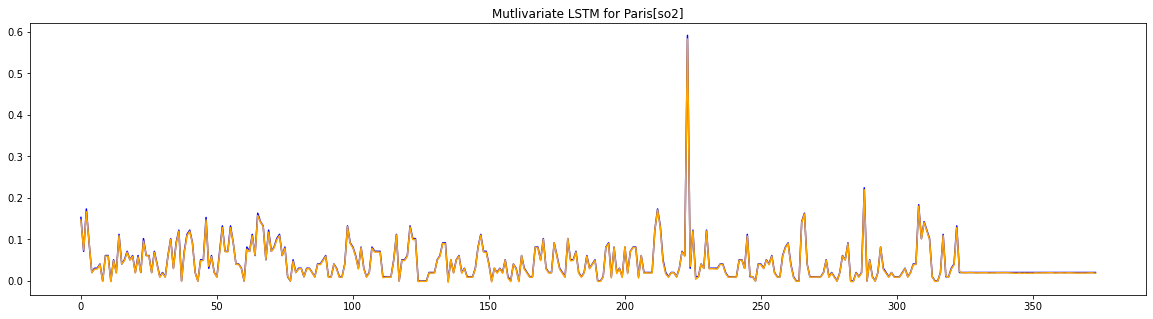

Multivariate LSTM MSE for Paris[pm10]:7.750568e-06
Multivariate LSTM RMSE for Paris[pm10]:0.002783984254509463
Multivariate LSTM MAE for Paris[pm10]:0.0019740514
Multivariate LSTM MAPE for Paris[pm10]:5135264000.0


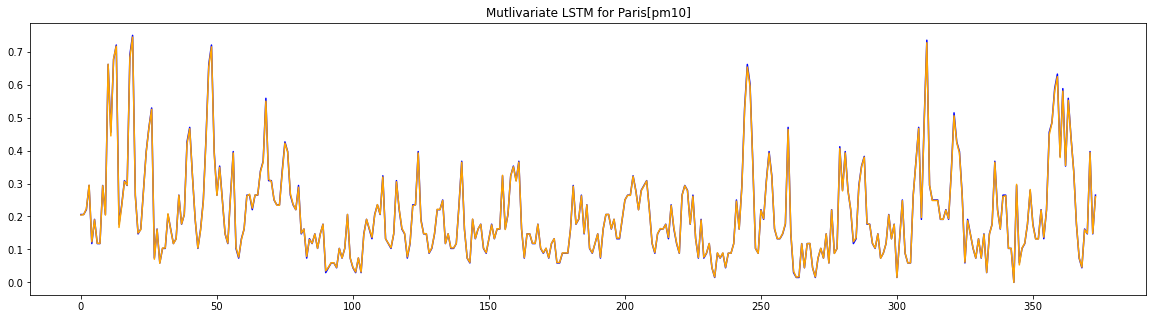

Multivariate LSTM MSE for Paris[pm25]:8.206885e-06
Multivariate LSTM RMSE for Paris[pm25]:0.0028647660565225275
Multivariate LSTM MAE for Paris[pm25]:0.0025026426
Multivariate LSTM MAPE for Paris[pm25]:29677191000.0


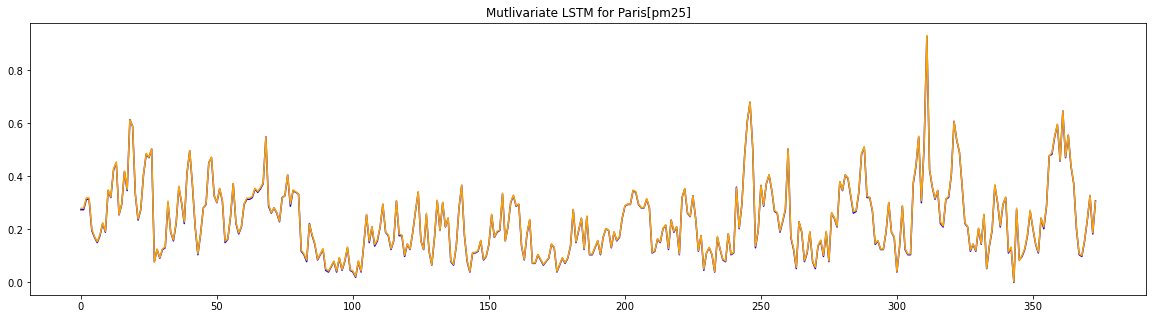

In [31]:
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Monthly seasonal predictions

In [32]:
Paris_Data_uni.index = pd.to_datetime(Paris_Data_uni.index)
Paris_Data_uni = Paris_Data_uni.resample("1m").mean().bfill()

In [33]:
Paris_o3.index = pd.to_datetime(Paris_o3.index)
Paris_monthly_o3 = Paris_o3.resample("1m").mean().bfill()

Paris_no2.index = pd.to_datetime(Paris_no2.index)
Paris_monthly_no2 = Paris_no2.resample("1m").mean().bfill()

Paris_so2.index = pd.to_datetime(Paris_so2.index)
Paris_monthly_so2 = Paris_so2.resample("1m").mean().bfill()

Paris_pm10.index = pd.to_datetime(Paris_pm10.index)
Paris_monthly_pm10 = Paris_pm10.resample("1m").mean().bfill()

Paris_pm25.index = pd.to_datetime(Paris_pm25.index)
Paris_monthly_pm25 = Paris_pm25.resample("1m").mean().bfill()

datasets = [Paris_monthly_o3.iloc[1: , :], Paris_monthly_no2.iloc[1: , :], 
            Paris_monthly_so2.iloc[1: , :], Paris_monthly_pm10.iloc[1: , :],
            Paris_monthly_pm25.iloc[1: , :]]

Univariate CNN MSE for Paris[no2]:0.006637473
Univariate CNN RMSE for Paris[no2]:0.0814706887476148
Univariate CNN MAE for Paris[no2]:0.06573903
Univariate CNN MAPE for Paris[no2]:0.34093753


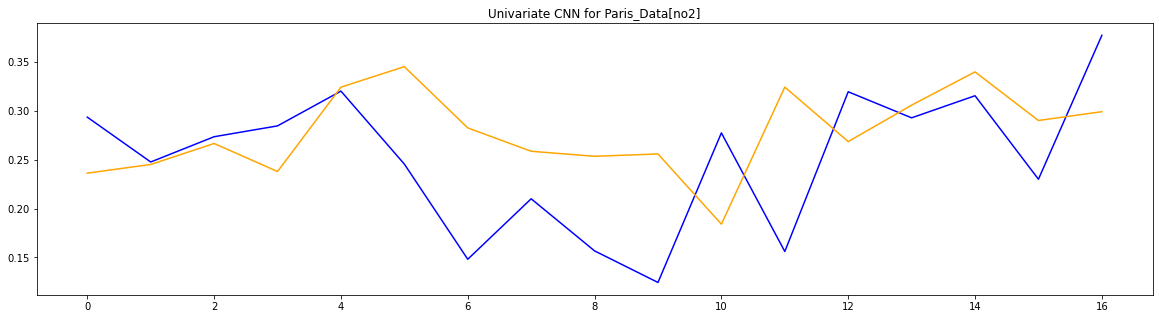

Univariate CNN MSE for Paris[o3]:0.010169416
Univariate CNN RMSE for Paris[o3]:0.10084352103486029
Univariate CNN MAE for Paris[o3]:0.07382387
Univariate CNN MAPE for Paris[o3]:0.1919856


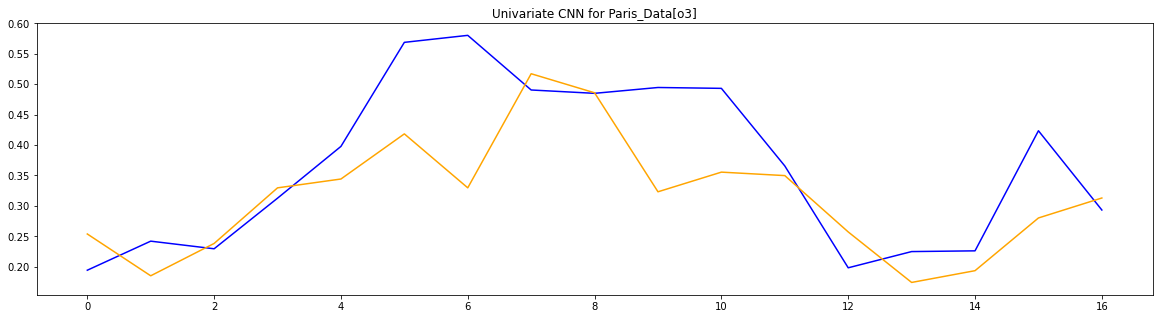

Univariate CNN MSE for Paris[pm10]:0.00617737
Univariate CNN RMSE for Paris[pm10]:0.07859624654414672
Univariate CNN MAE for Paris[pm10]:0.06608712
Univariate CNN MAPE for Paris[pm10]:0.39291638


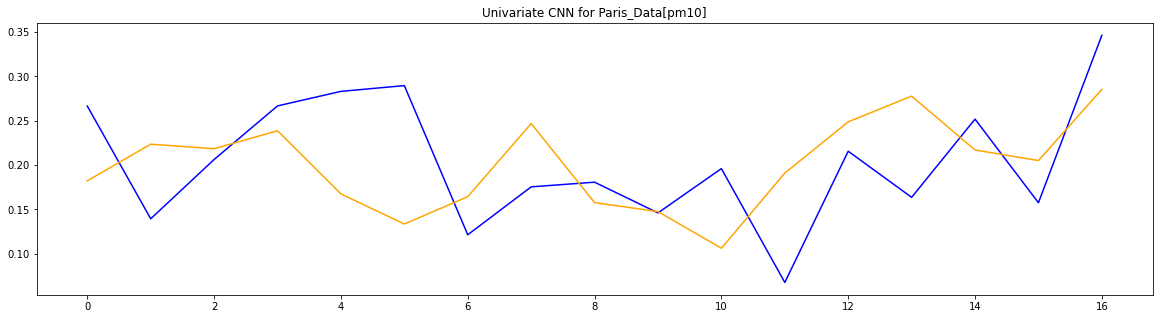

Univariate CNN MSE for Paris[pm25]:0.0072321263
Univariate CNN RMSE for Paris[pm25]:0.08504190916361774
Univariate CNN MAE for Paris[pm25]:0.07139202
Univariate CNN MAPE for Paris[pm25]:0.3727549


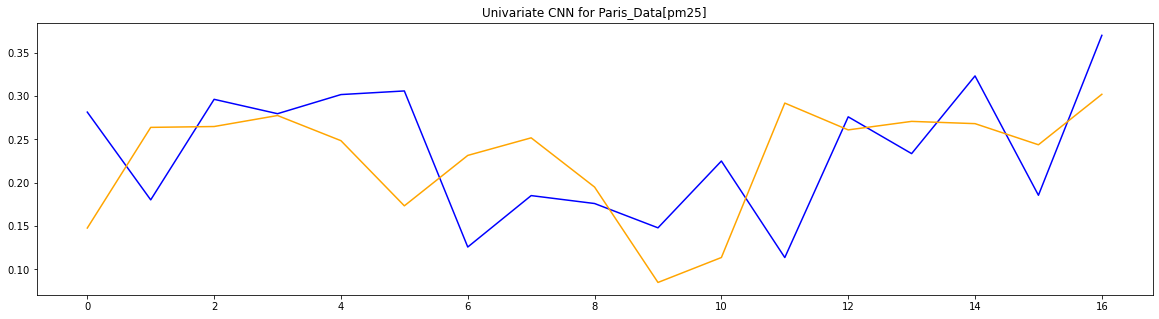

Univariate CNN MSE for Paris[so2]:0.0003140549
Univariate CNN RMSE for Paris[so2]:0.01772159401016348
Univariate CNN MAE for Paris[so2]:0.014010882
Univariate CNN MAPE for Paris[so2]:0.35212925


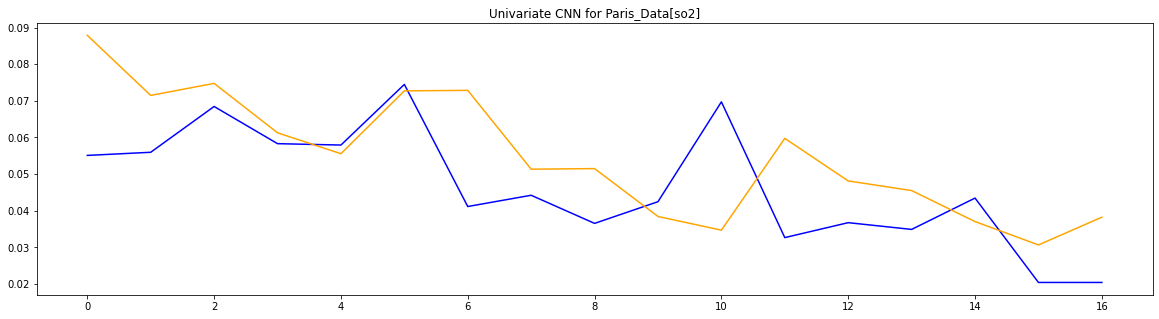

Multivariate CNN MSE for Paris[o3]:0.0024785916
Multivariate CNN RMSE for Paris[o3]:0.04978545602982822
Multivariate CNN MAE for Paris[o3]:0.040227786
Multivariate CNN MAPE for Paris[o3]:0.12815031


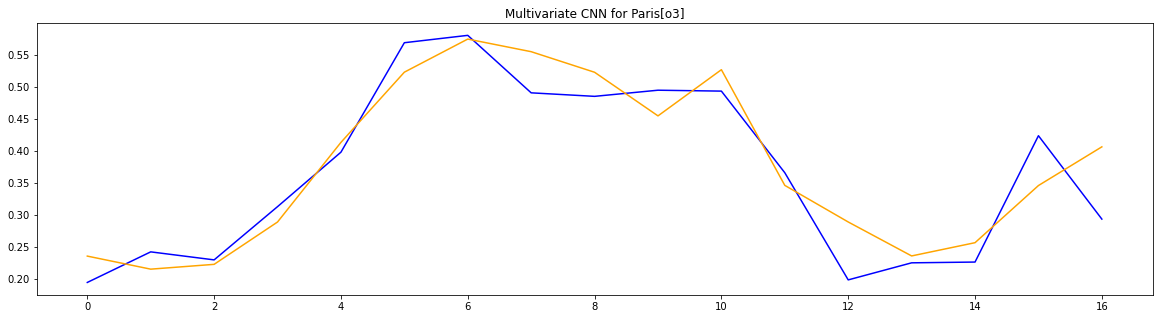

Multivariate CNN MSE for Paris[no2]:0.0030046096
Multivariate CNN RMSE for Paris[no2]:0.054814319362371834
Multivariate CNN MAE for Paris[no2]:0.038301
Multivariate CNN MAPE for Paris[no2]:0.17626008


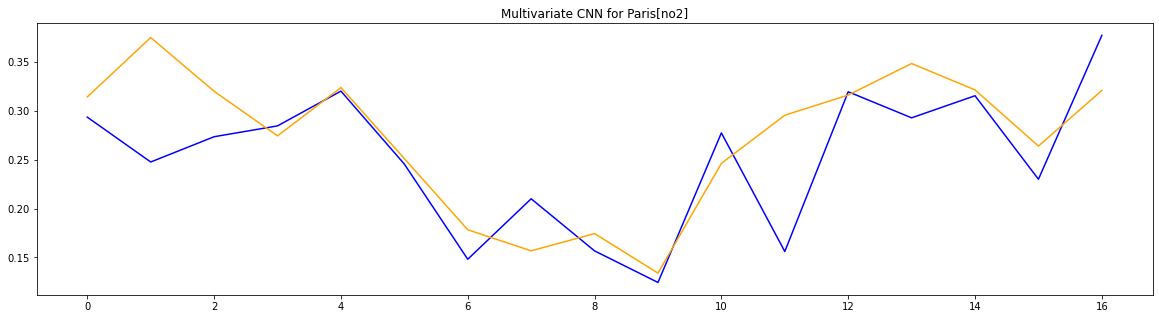

Multivariate CNN MSE for Paris[so2]:0.00048434013
Multivariate CNN RMSE for Paris[so2]:0.022007728771839926
Multivariate CNN MAE for Paris[so2]:0.017387126
Multivariate CNN MAPE for Paris[so2]:0.48826623


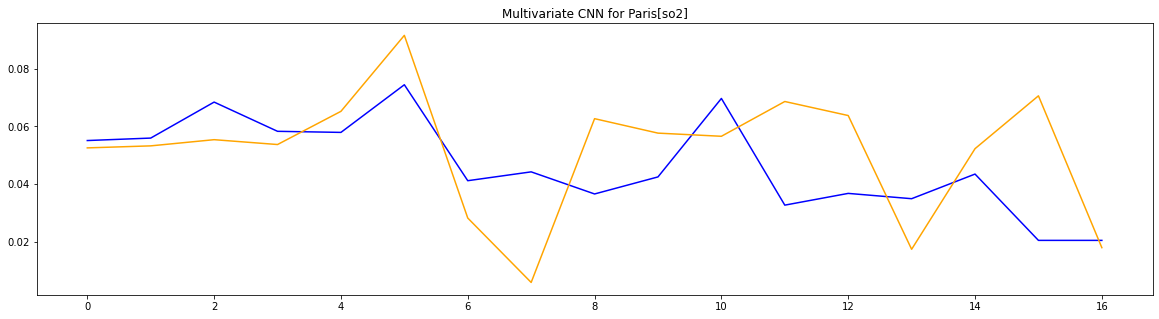

Multivariate CNN MSE for Paris[pm10]:0.003431675
Multivariate CNN RMSE for Paris[pm10]:0.05858050037623967
Multivariate CNN MAE for Paris[pm10]:0.047988024
Multivariate CNN MAPE for Paris[pm10]:0.2533501


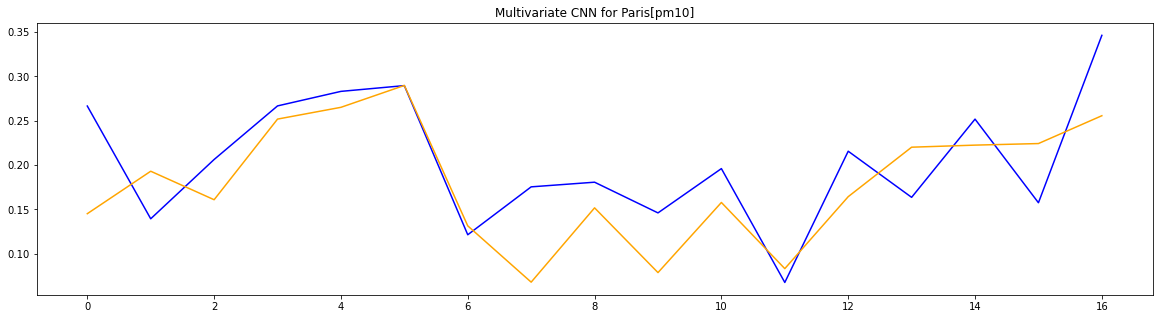

Multivariate CNN MSE for Paris[pm25]:0.0021720894
Multivariate CNN RMSE for Paris[pm25]:0.0466056800687541
Multivariate CNN MAE for Paris[pm25]:0.03873386
Multivariate CNN MAPE for Paris[pm25]:0.19872779


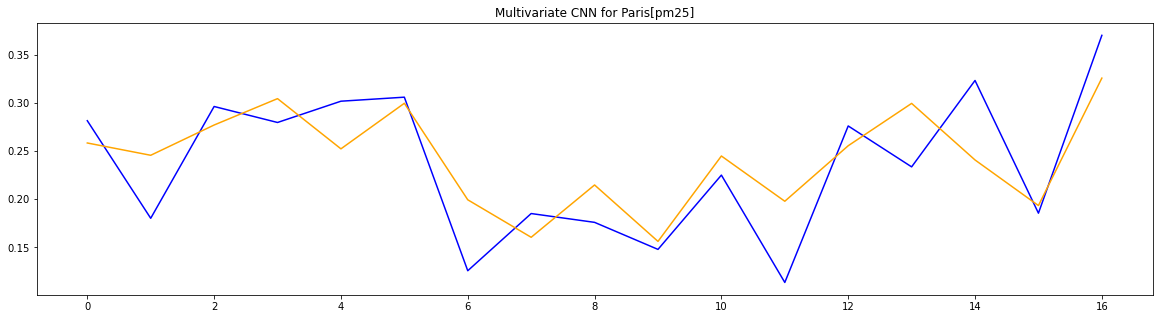

Univariate LSTM MSE for Paris[no2]:0.005622982
Univariate LSTM RMSE for Paris[no2]:0.07498654577654731
Univariate LSTM MAE for Paris[no2]:0.0609857
Univariate LSTM MAPE for Paris[no2]:0.32118222


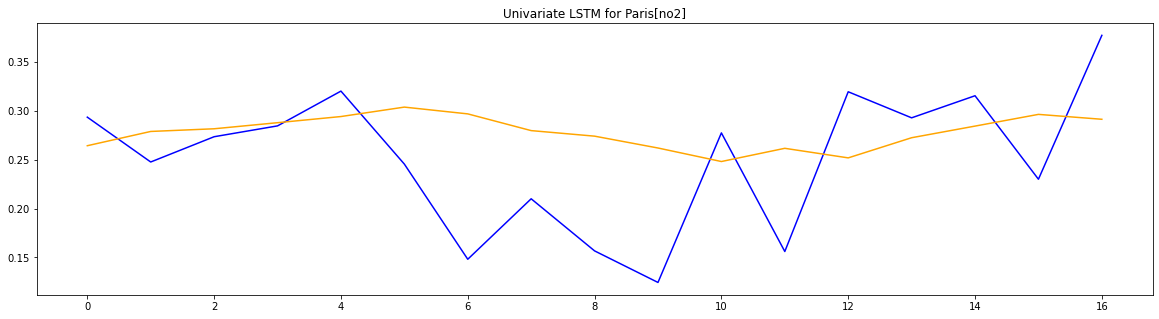

Univariate LSTM MSE for Paris[o3]:0.01059965
Univariate LSTM RMSE for Paris[o3]:0.10295460379507199
Univariate LSTM MAE for Paris[o3]:0.08184987
Univariate LSTM MAPE for Paris[o3]:0.21353376


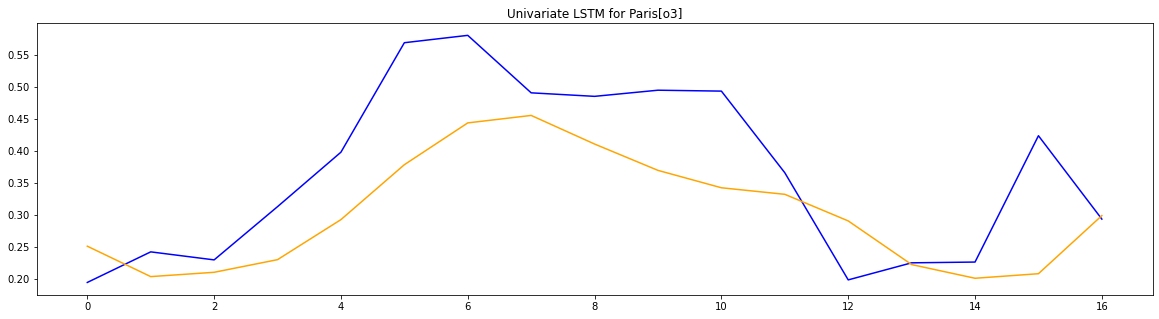

Univariate LSTM MSE for Paris[pm10]:0.0050876904
Univariate LSTM RMSE for Paris[pm10]:0.07132804797482797
Univariate LSTM MAE for Paris[pm10]:0.059900902
Univariate LSTM MAPE for Paris[pm10]:0.38506076


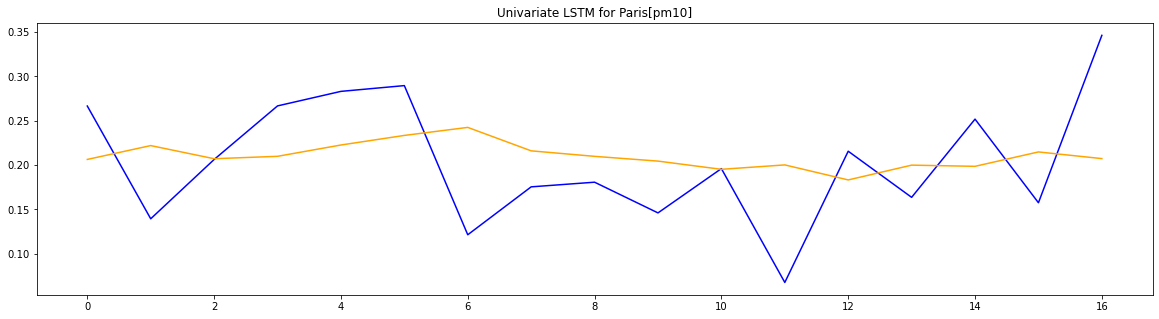

Univariate LSTM MSE for Paris[pm25]:0.005621655
Univariate LSTM RMSE for Paris[pm25]:0.07497769610243701
Univariate LSTM MAE for Paris[pm25]:0.0664764
Univariate LSTM MAPE for Paris[pm25]:0.3368439


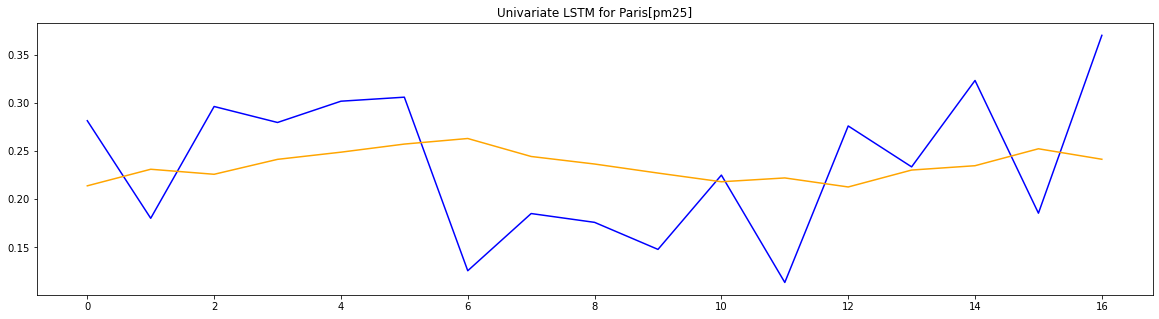

Univariate LSTM MSE for Paris[so2]:0.00039014727
Univariate LSTM RMSE for Paris[so2]:0.01975214586934338
Univariate LSTM MAE for Paris[so2]:0.017902091
Univariate LSTM MAPE for Paris[so2]:0.5065793


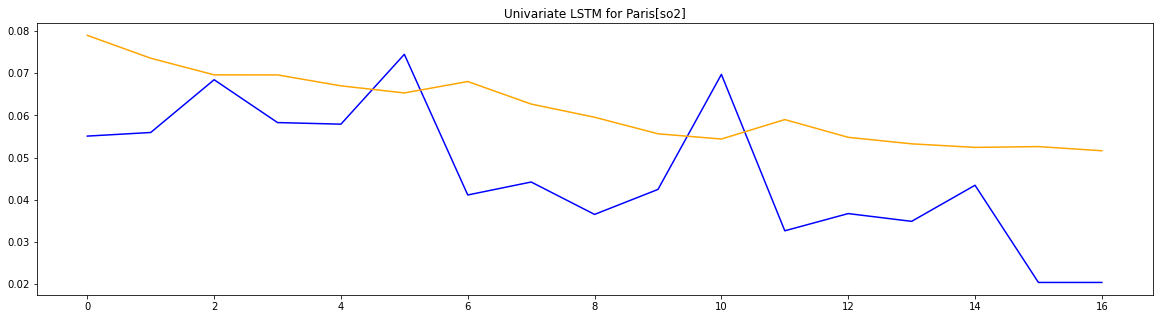

Multivariate LSTM MSE for Paris[o3]:0.0007147153
Multivariate LSTM RMSE for Paris[o3]:0.026734159406517834
Multivariate LSTM MAE for Paris[o3]:0.020073613
Multivariate LSTM MAPE for Paris[o3]:0.05298134


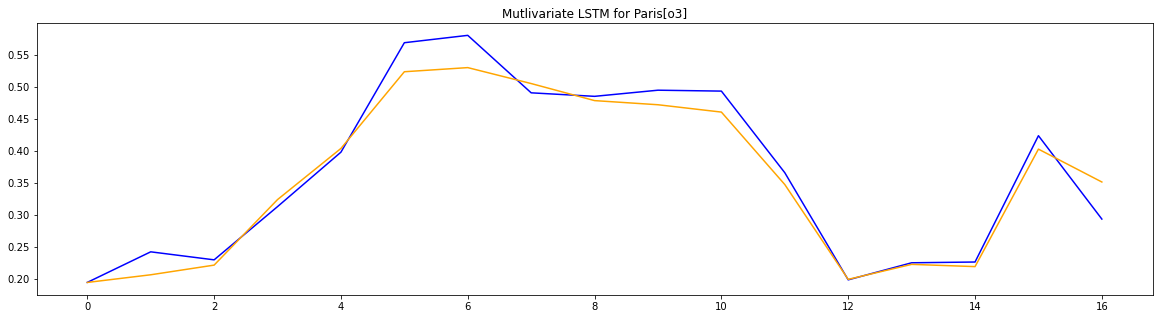

Multivariate LSTM MSE for Paris[no2]:0.0010591127
Multivariate LSTM RMSE for Paris[no2]:0.032544012062479345
Multivariate LSTM MAE for Paris[no2]:0.028097525
Multivariate LSTM MAPE for Paris[no2]:0.13085645


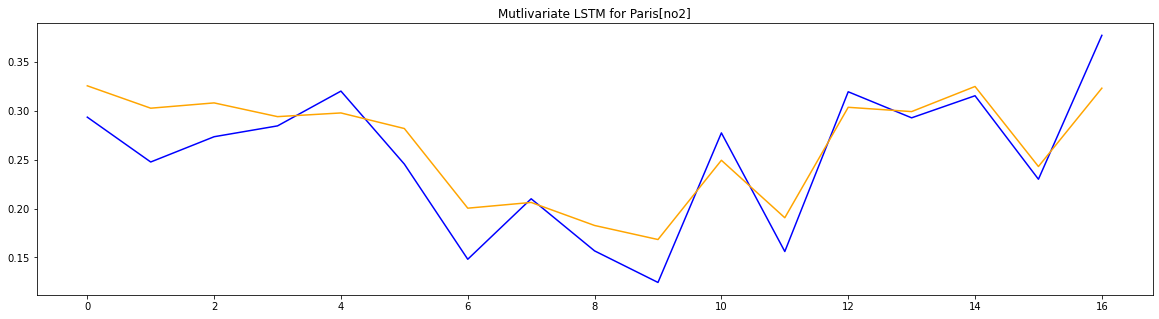

Multivariate LSTM MSE for Paris[so2]:0.00027601258
Multivariate LSTM RMSE for Paris[so2]:0.01661362630430619
Multivariate LSTM MAE for Paris[so2]:0.015444237
Multivariate LSTM MAPE for Paris[so2]:0.42050317


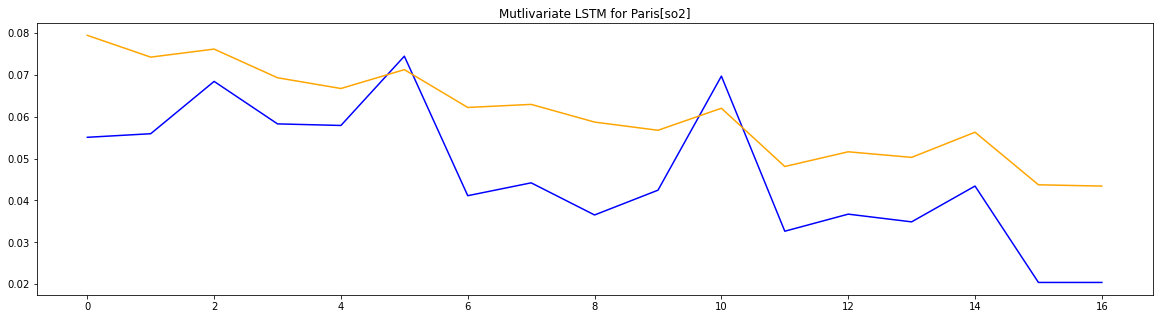

Multivariate LSTM MSE for Paris[pm10]:0.0014641779
Multivariate LSTM RMSE for Paris[pm10]:0.03826457701790456
Multivariate LSTM MAE for Paris[pm10]:0.03219529
Multivariate LSTM MAPE for Paris[pm10]:0.1695601


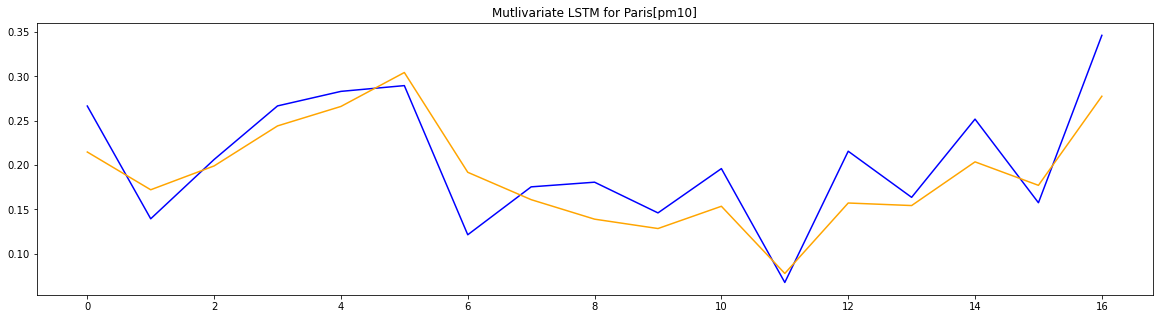

Multivariate LSTM MSE for Paris[pm25]:0.0008855399
Multivariate LSTM RMSE for Paris[pm25]:0.02975802280059278
Multivariate LSTM MAE for Paris[pm25]:0.02367694
Multivariate LSTM MAPE for Paris[pm25]:0.121454686


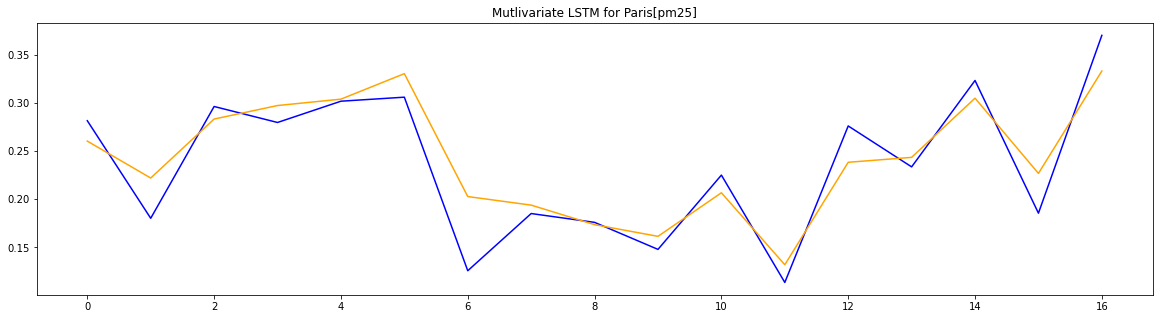

In [34]:
n_steps = 12

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()